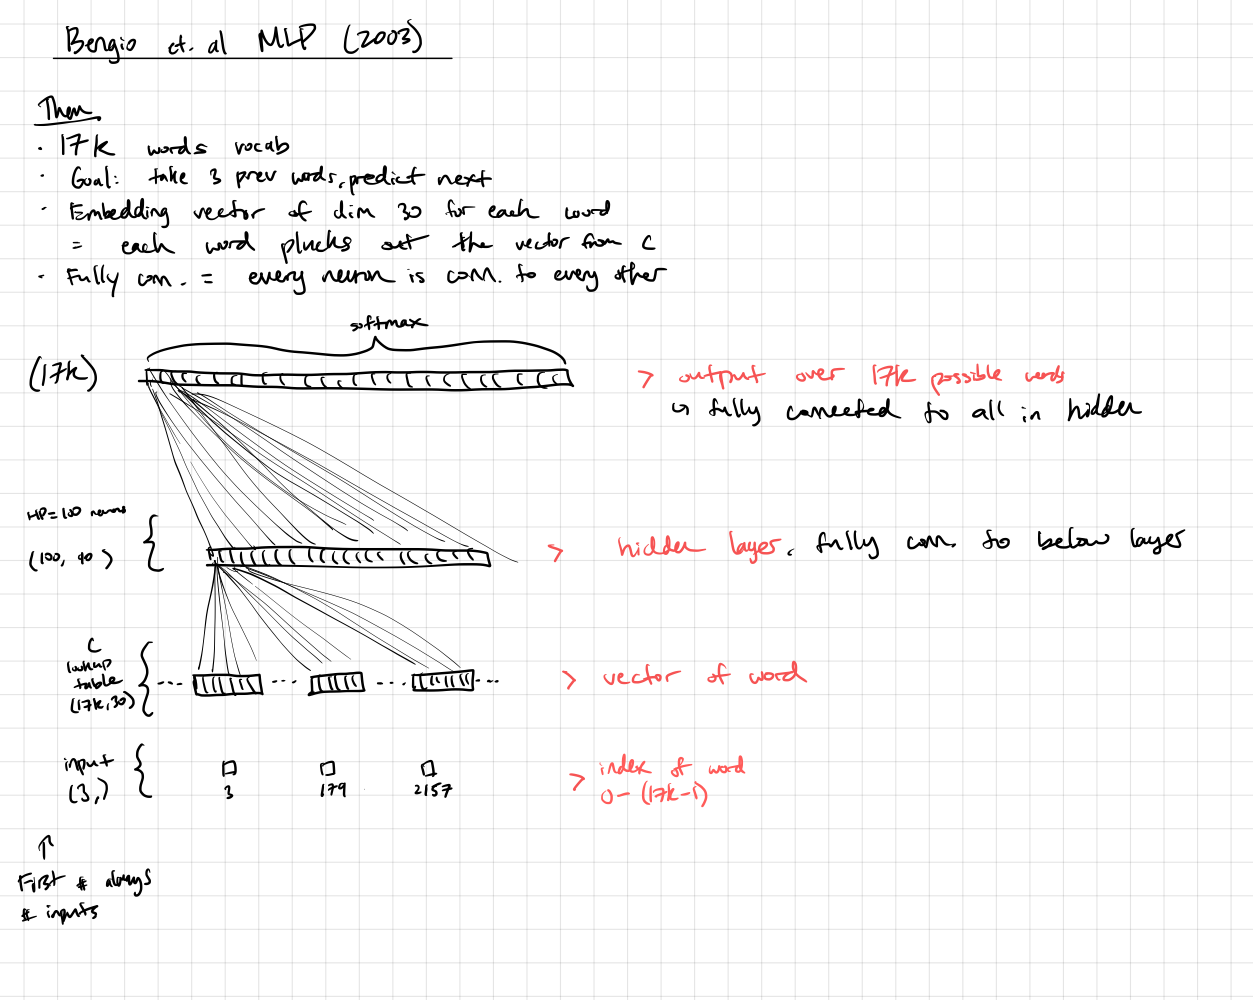


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open("names.txt") as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build vocab and mappings to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(f"{itos=}")

itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [99]:
# build the dataset

block_size = 3  # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:  # Only 5 for now

    print(w)
    context = [0] * block_size
    for ch in w + '.':  # add end character marker '.'
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]  # crop and append (rolling window)

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [100]:
X.shape, X.dtype, Y.shape, Y.dtype
# 32 examples, 3 dim each for X, 1 dim output Y

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [101]:
# Create lookup table C: cramming 27d words into 2d space
C = torch.randn((27, 2))

In [102]:
# These are equivalent
display(C[5])
display(F.one_hot(torch.tensor(5), num_classes=27).float() @ C)

tensor([0.5307, 0.1567])

tensor([0.5307, 0.1567])

In [103]:
# Indexing with lists/tensors with PyTorch
display(C[[5, 6, 7]])
display(C[torch.tensor([5, 6, 7])])
display(C[torch.tensor([5, 6, 7, 7, 7])])  # index same index multiple times

tensor([[ 0.5307,  0.1567],
        [-0.8549,  0.8212],
        [ 0.6769,  0.1039]])

tensor([[ 0.5307,  0.1567],
        [-0.8549,  0.8212],
        [ 0.6769,  0.1039]])

tensor([[ 0.5307,  0.1567],
        [-0.8549,  0.8212],
        [ 0.6769,  0.1039],
        [ 0.6769,  0.1039],
        [ 0.6769,  0.1039]])

In [104]:
# So this works: For each of the 32 x 3 integers, we retrieve the embedding vector
# 32 (for each training example) x 3 (number of characters context) x 2 (dimension of embedding vector)
display(C[X].shape)

# This retrieves the embedding for the example index 13, 2nd dimension (3rd character)
display(C[X][13, 2])

emb = C[X]

torch.Size([32, 3, 2])

tensor([0.8877, 1.0461])

In [105]:
# Our hidden layer
# 6 inputs, 100 outputs (hyperparam) (hidden layer size or hyperparameter)
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [106]:
# Now we want to multiply our input with our hidden net but we can't do emb @ W1 + b1 because shapes are different
# [32,3,2] cannot multiply [6,100]: we need to convert to [32,6]

# One way: concat the 3 parts on dim=1
# - Grab all examples, each part, and all the embedding
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [107]:
# Another way
torch.cat(torch.unbind(emb, dim=1)).shape

torch.Size([96, 2])

In [108]:
# Example of using views: which are efficient bc they dont use extra memory or anything
a = torch.arange(18)
print(a, a.shape)
print(a.view(3, 3, 2))
print(a.view(9, 2))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]) torch.Size([18])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])
tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])


In [109]:
# Use views for emb
display(emb)
display(emb.view(32, 6))

tensor([[[ 1.1694, -0.1266],
         [ 1.1694, -0.1266],
         [ 1.1694, -0.1266]],

        [[ 1.1694, -0.1266],
         [ 1.1694, -0.1266],
         [ 0.5307,  0.1567]],

        [[ 1.1694, -0.1266],
         [ 0.5307,  0.1567],
         [ 0.8250, -0.7168]],

        [[ 0.5307,  0.1567],
         [ 0.8250, -0.7168],
         [ 0.8250, -0.7168]],

        [[ 0.8250, -0.7168],
         [ 0.8250, -0.7168],
         [ 0.8877,  1.0461]],

        [[ 1.1694, -0.1266],
         [ 1.1694, -0.1266],
         [ 1.1694, -0.1266]],

        [[ 1.1694, -0.1266],
         [ 1.1694, -0.1266],
         [ 0.0568, -0.5375]],

        [[ 1.1694, -0.1266],
         [ 0.0568, -0.5375],
         [-0.0973,  3.4334]],

        [[ 0.0568, -0.5375],
         [-0.0973,  3.4334],
         [ 0.4904,  0.3908]],

        [[-0.0973,  3.4334],
         [ 0.4904,  0.3908],
         [-0.4705, -1.0598]],

        [[ 0.4904,  0.3908],
         [-0.4705, -1.0598],
         [ 0.4904,  0.3908]],

        [[-0.4705, -1

tensor([[ 1.1694, -0.1266,  1.1694, -0.1266,  1.1694, -0.1266],
        [ 1.1694, -0.1266,  1.1694, -0.1266,  0.5307,  0.1567],
        [ 1.1694, -0.1266,  0.5307,  0.1567,  0.8250, -0.7168],
        [ 0.5307,  0.1567,  0.8250, -0.7168,  0.8250, -0.7168],
        [ 0.8250, -0.7168,  0.8250, -0.7168,  0.8877,  1.0461],
        [ 1.1694, -0.1266,  1.1694, -0.1266,  1.1694, -0.1266],
        [ 1.1694, -0.1266,  1.1694, -0.1266,  0.0568, -0.5375],
        [ 1.1694, -0.1266,  0.0568, -0.5375, -0.0973,  3.4334],
        [ 0.0568, -0.5375, -0.0973,  3.4334,  0.4904,  0.3908],
        [-0.0973,  3.4334,  0.4904,  0.3908, -0.4705, -1.0598],
        [ 0.4904,  0.3908, -0.4705, -1.0598,  0.4904,  0.3908],
        [-0.4705, -1.0598,  0.4904,  0.3908,  0.8877,  1.0461],
        [ 1.1694, -0.1266,  1.1694, -0.1266,  1.1694, -0.1266],
        [ 1.1694, -0.1266,  1.1694, -0.1266,  0.8877,  1.0461],
        [ 1.1694, -0.1266,  0.8877,  1.0461, -0.4705, -1.0598],
        [ 0.8877,  1.0461, -0.4705, -1.0

In [110]:
emb

tensor([[[ 1.1694, -0.1266],
         [ 1.1694, -0.1266],
         [ 1.1694, -0.1266]],

        [[ 1.1694, -0.1266],
         [ 1.1694, -0.1266],
         [ 0.5307,  0.1567]],

        [[ 1.1694, -0.1266],
         [ 0.5307,  0.1567],
         [ 0.8250, -0.7168]],

        [[ 0.5307,  0.1567],
         [ 0.8250, -0.7168],
         [ 0.8250, -0.7168]],

        [[ 0.8250, -0.7168],
         [ 0.8250, -0.7168],
         [ 0.8877,  1.0461]],

        [[ 1.1694, -0.1266],
         [ 1.1694, -0.1266],
         [ 1.1694, -0.1266]],

        [[ 1.1694, -0.1266],
         [ 1.1694, -0.1266],
         [ 0.0568, -0.5375]],

        [[ 1.1694, -0.1266],
         [ 0.0568, -0.5375],
         [-0.0973,  3.4334]],

        [[ 0.0568, -0.5375],
         [-0.0973,  3.4334],
         [ 0.4904,  0.3908]],

        [[-0.0973,  3.4334],
         [ 0.4904,  0.3908],
         [-0.4705, -1.0598]],

        [[ 0.4904,  0.3908],
         [-0.4705, -1.0598],
         [ 0.4904,  0.3908]],

        [[-0.4705, -1

In [111]:
emb.view(32, 6)

tensor([[ 1.1694, -0.1266,  1.1694, -0.1266,  1.1694, -0.1266],
        [ 1.1694, -0.1266,  1.1694, -0.1266,  0.5307,  0.1567],
        [ 1.1694, -0.1266,  0.5307,  0.1567,  0.8250, -0.7168],
        [ 0.5307,  0.1567,  0.8250, -0.7168,  0.8250, -0.7168],
        [ 0.8250, -0.7168,  0.8250, -0.7168,  0.8877,  1.0461],
        [ 1.1694, -0.1266,  1.1694, -0.1266,  1.1694, -0.1266],
        [ 1.1694, -0.1266,  1.1694, -0.1266,  0.0568, -0.5375],
        [ 1.1694, -0.1266,  0.0568, -0.5375, -0.0973,  3.4334],
        [ 0.0568, -0.5375, -0.0973,  3.4334,  0.4904,  0.3908],
        [-0.0973,  3.4334,  0.4904,  0.3908, -0.4705, -1.0598],
        [ 0.4904,  0.3908, -0.4705, -1.0598,  0.4904,  0.3908],
        [-0.4705, -1.0598,  0.4904,  0.3908,  0.8877,  1.0461],
        [ 1.1694, -0.1266,  1.1694, -0.1266,  1.1694, -0.1266],
        [ 1.1694, -0.1266,  1.1694, -0.1266,  0.8877,  1.0461],
        [ 1.1694, -0.1266,  0.8877,  1.0461, -0.4705, -1.0598],
        [ 0.8877,  1.0461, -0.4705, -1.0

In [112]:
# Our hidden layer
# 6 inputs, 100 outputs (hyperparam) (hidden layer size or hyperparameter)
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
# hidden layer, tanh makes it -1 to 1
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # -1 in emb.view means infer

In [113]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [114]:
b1.shape

torch.Size([100])

In [115]:
# Check broadcast:

# Broadcasting check: This is correct because the same 100D bias vector is added to each of the 32 training examples
# 32, 100
# (1), 100

# Will copy vertically every one of the rows of 32
# This is correct because the same bias vector will be added to all the rows of the examples

In [116]:
h.shape

torch.Size([32, 100])

In [117]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [118]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [119]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [120]:
# given the label, the probability of the model assigns to the label
loss = -prob[torch.arange(32), Y].log().mean()

# Cleaned Up


In [202]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:  # Change to all
    context = [0] * block_size
    for ch in w + '.':  # add end character marker '.'
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # crop and append (rolling window)

X = torch.tensor(X)
Y = torch.tensor(Y)

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)  # number of parameters in total

3481

In [203]:
for p in parameters:
    p.requires_grad = True

In [204]:
# Find best learning rate:
lre = torch.linspace(-3, 0, 1000)  # 1000 nums between 0.001 and 1
lrs = 10**lre  # we step linearly through exponents, beginning very slow but gets bigger

In [207]:
# All together
lri = []   # learning rates we used
lossi = []  # losses that resulted

for i in range(1000):
    # CREATE MINIBATCH:
    #   Select randomly 32 rows from the training set
    ix = torch.randint(0, X.shape[0], (32,))

    # FWD:
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # BWD:
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE:
    lr = lrs[i]  # get learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

5.888940811157227


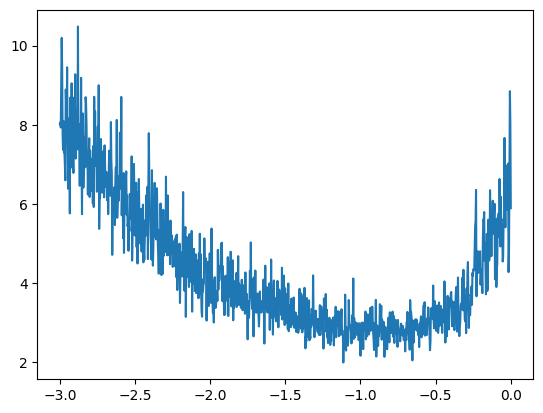

In [208]:
plt.plot(lri, lossi)
# In the beginning low learning rate = no learning happens then becomes unstable

In [ ]:
# So then it seems like -1 is a good learning rate.

In [241]:
# Build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:  # Change to all
    context = [0] * block_size
    for ch in w + '.':  # add end character marker '.'
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # crop and append (rolling window)

X = torch.tensor(X)
Y = torch.tensor(Y)

# Build model
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)  # number of parameters in total

# Add Grad
for p in parameters:
    p.requires_grad = True

for i in range(10_000):
    # CREATE MINIBATCH:
    #   Select randomly 32 rows from the training set
    ix = torch.randint(0, X.shape[0], (32,))

    # FWD:
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # BWD:
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE:
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

In [242]:
# Full loss
emb = C[X]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5760, grad_fn=<NllLossBackward0>)

In [243]:
# training, dev/validation, test split
# 80%, 10%, 10%
# training: used to optimize params using gradient descent
# dev/validation: used to tune hyperparameters
# test: validate performance of whole model at end only. only do this few times or you introduce into the model its info

# build the dataset
# context length: how many characters do we take to predict the next one?
import random
block_size = 3


def build_dataset(words):
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [264]:
# Build model (same)
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameters in total

# Add Grad
for p in parameters:
    p.requires_grad = True

3481


In [265]:
# TRAIN (Adjust to use Xtr and Ytr instead of X and Y)


for i in range(10_000):
    # CREATE MINIBATCH:
    #   Select randomly 32 rows from the training set
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # FWD:
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # BWD:
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE:
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.5956225395202637


In [266]:
# Full loss with split

def calculate_loss(x, y):
    emb = C[x]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, y)
    return loss


print(calculate_loss(Xdev, Ydev))
print(calculate_loss(Xtr, Ytr))
# Our training loss and dev loss are the same, which means that the model is underfitting (it is too small)

tensor(2.5663, grad_fn=<NllLossBackward0>)
tensor(2.5716, grad_fn=<NllLossBackward0>)


In [267]:
# Build model (same) but make it bigger
HP_NEURONS = 300  # hyperparam

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, HP_NEURONS), generator=g)
b1 = torch.randn(HP_NEURONS, generator=g)
W2 = torch.randn((HP_NEURONS, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameters in total

# Add Grad
for p in parameters:
    p.requires_grad = True

10281


In [284]:
# TRAIN
lri = []
lossi = []
stepi = []

for i in range(30_000):
    # CREATE MINIBATCH:
    #   Select randomly 32 rows from the training set
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # FWD:
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # BWD:
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE:
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # TRACK:
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

print(loss.item())

2.0617685317993164


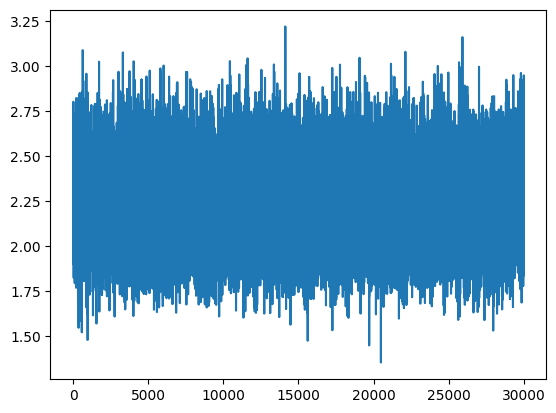

In [285]:
plt.plot(stepi, lossi)

In [286]:
# Full loss with bigger model

print(calculate_loss(Xdev, Ydev))
print(calculate_loss(Xtr, Ytr))
# Our training loss and dev loss are the same, which means that the model is underfitting (it is too small)

tensor(2.2394, grad_fn=<NllLossBackward0>)
tensor(2.2292, grad_fn=<NllLossBackward0>)


### Reasons why the model couldn't be performing:

- Size of tanh (we increased it but still bad)
- The mini batch size 32 is too small and introduces too much noise to the training set.
- The dimension of 2 to represent the characters is too small.
- Only looking at 3 characters is not enough


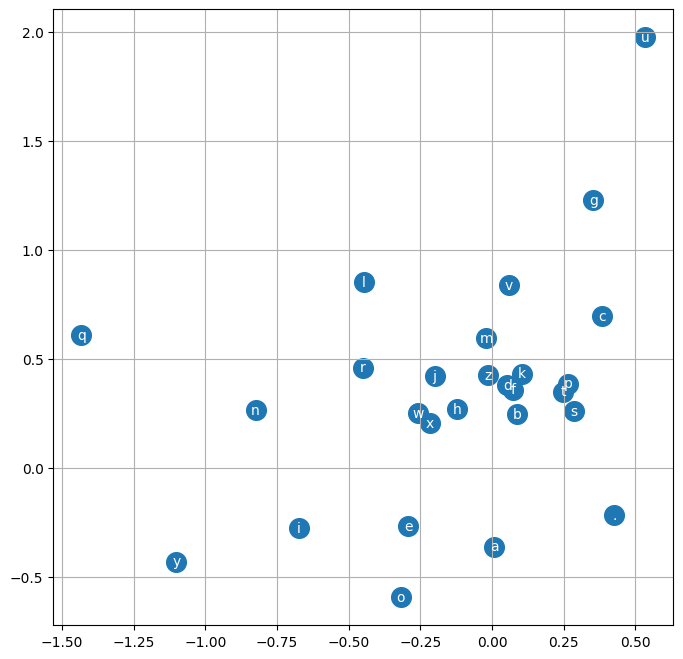

In [287]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],
             ha="center", va="center", color='white')
plt.grid('minor')

We note that the vowels A-E-I-O-U are clustered together because the model learned that they're kind of similar. Whereas Q and the dot are very by themselves because they're very different.


In [311]:
# Build model (same) but change embedding dim
HP_NEURONS = 250  # hyperparam
HP_EMB_DIM = 15

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((27, HP_EMB_DIM), generator=g)  # change
W1 = torch.randn((3 * HP_EMB_DIM, HP_NEURONS), generator=g)  # change
b1 = torch.randn(HP_NEURONS, generator=g)
W2 = torch.randn((HP_NEURONS, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameters in total

# Add Grad
for p in parameters:
    p.requires_grad = True

18682


In [312]:
lri = []
lossi = []
stepi = []

In [318]:
# TRAIN
CONCAT_SIZE = block_size * HP_EMB_DIM

for i in range(100_000):
    # CREATE MINIBATCH:
    #   Select randomly 32 rows from the training set
    ix = torch.randint(0, Xtr.shape[0], (64,))

    # FWD:
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, CONCAT_SIZE) @ W1 + b1)  # change from 6 to 30
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # BWD:
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE:
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # TRACK:
    # lri.append(lre[i])
    stepi.append(i)
    # want to plot log loss instead of loss because of the hockey stick.
    lossi.append(loss.log10().item())

print(loss.item())

2.134699821472168


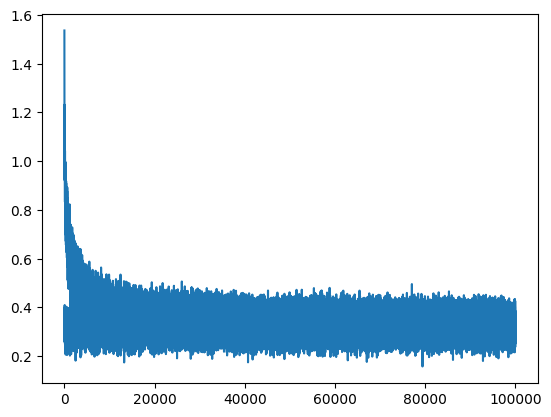

In [319]:
plt.plot(stepi, lossi)

In [320]:
# Full loss with split

# Fix magic number 6 to 30 lol
def calculate_loss(x, y):
    emb = C[x]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, CONCAT_SIZE) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, y)
    return loss


print(calculate_loss(Xdev, Ydev))
print(calculate_loss(Xtr, Ytr))
# Oh yeah we beat Karpathy 2.17 by fiddling the params and running all training an extra time

tensor(2.1456, grad_fn=<NllLossBackward0>)
tensor(2.0716, grad_fn=<NllLossBackward0>)


In [321]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carlah.
americk.
haimri.
reity.
skansh.
eja.
hutca.
perric.
kaeli.
nellara.
chaiin.
kaleigh.
ham.
pori.
quintis.
lilah.
jadis.
wajerma.
jaryn.
kakael.
